## config

In [1]:
from os.path import join, exists, realpath
from os import makedirs

class Config():
  def __init__(self):
    # Paths
    self.input_path = join(realpath('.'), 'data', 'input')
      
    self.NI_data_path = join(self.input_path, 'People_NI_081124.csv') # 3,064 records EN 
    self.Wikidata_data_path = join(self.input_path, 'People_Wikidata_081124.csv') # 3.792 records EN
    self.RKD_data_path = join(self.input_path, 'RKDartists_architects_designers_noNationality_union.csv') # 4.331K records En


    self.results_path = join(realpath('.'), 'results')
    if not exists(self.results_path):
        makedirs(self.results_path)

    self.validation_sheets_path = join(self.results_path, 'validation')
    if not exists(self.validation_sheets_path):
        makedirs(self.validation_sheets_path)

    self.extract_n = 'all' # extract first n records if 'all' extract all records

    # Embeddings
    # TransH is a suitable choice for handling complex relational patterns in knowledge graphs,
    # including 1-to-many and many-to-1 relationships.
    # It builds on the strengths of TransE by introducing relation-specific hyperplanes,
    # making it more versatile for a wider range of relational data. Using TransH in PyKEEN can help you capture these relationships more effectively.
    self.embeddings_method = "TransH"

In [2]:
config = Config()

# ETL

In [3]:
import json
from os import makedirs
from os.path import join, exists, realpath

import pandas as pd
import pykeen.pipeline as pipeline
from pykeen.pipeline import PipelineResult
from pykeen.models import TransH  # should be loaded based on config file.
import numpy as np
from pykeen.triples import TriplesFactory

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

# import config


class ETL():
    def __init__(self, src_path, src_name):
        self.src_path = src_path
        self.src_name = src_name
        self.src_results_path = join(config.results_path, src_name)

        # Create mappings for entities and relations
        # self.entity_to_id = {}
        # self.relation_to_id = {}
        # self.next_entity_id = 0
        # self.next_relation_id = 0

        # self.get_triples_factory = None
        self.entity_embeddings, self.relations_embeddings, self.model = None, None, None
        self.embeddings_entity_np = None # numpy array format of entity embeddings

        self.subjects = []  # List to store unique subjects
        self.triples = []
        
    def try_parse_date(self, date_string):
        try:
            return parser.parse(date_string).date().strftime(
                '%Y-%m-%d')  # extract date part only and remove timespan part
        except (ValueError, TypeError) as e:
            # print(f"Error parsing date: {e}")
            return None
            
    def extract(self, keys, header=None):
        """
        Loads dataframe with only the given keys
        """
        df = pd.read_csv(self.src_path, names=keys, usecols=[i for i in range(len(keys))], dtype='str', header=header)
        df.dropna(how='all', inplace=True)
        df.fillna('', inplace=True)

        if config.extract_n != 'all':
            df = df.head(config.extract_n)

        print(f"Extracted {config.extract_n} records from {self.src_name}")

        return df
    
    def clean (self, df):
        pass
        
    def transform(self, raw_df, triples_path):
        """
        Transforms the dataframe into triples and save these triples in disk
        """
    
        df = self.clean(raw_df)
    
        preds = df.columns.tolist()
        for p in preds:
            print(p)
    
        
        # parses the dataframe into triples = [(s, p, o)]        
        for p in preds[1:]:
            for i, row in df.iterrows():
                s = row[preds[0]]
    
                o = row[p]
                # avoid filling empty triples
                if o == '':
                    continue
    
                if s not in self.subjects:
                    self.subjects += [s]
    
                multi_valued_o = o.split('<|>')
                for oi in multi_valued_o:
                    if [s, p, o] not in self.triples:
                         self.triples += [[s, p, oi]]
    
    
        # dump triples in a file on the disk
        df = pd.DataFrame(self.triples, columns=['s', 'p', 'o'], index=None)
        df.to_csv(triples_path)
        
        print(f'Saved {len(self.triples)} triples at {self.triples_path}')

        # store subjects to disk as well
        df = pd.DataFrame({'subjects': self.subjects})
        df.to_csv(join(self.src_results_path, 'subjects.csv'))


    def load(self, triples_path):
        """
        Loads pre-trained embeddings
        """
        df = pd.read_csv(triples_path, header=0, dtype=str)

        self.triples = df[['s', 'p', 'o']].values

        print(f'Loaded {len(self.triples)} triples from {triples_path}')

        return self.triples
        
    def run(self, keys, save_triples_to, header=None):
        df = self.extract(keys, header=header)
        self.transform(df, save_triples_to)
        triples = self.load(save_triples_to)
        return triples

In [4]:
def get_record(triples, s_uri):
    props = {}
    [props.update({prop:val}) for s,prop, val in triples if s == s_uri]
    return props

In [5]:
import torch

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
device

'cuda'

# Embeddings Handler

In [8]:
def to_embeddings(triples, save_to):
    """
    Transforms the saved triples into embeddings space using pykeen
    """

    # Create a TriplesFactory from the converted triples
    triples_factory = TriplesFactory.from_labeled_triples(triples)

    # Check if GPU is available and set the device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    print(f"Using device: {device}")

    result = pipeline.pipeline(
        training=triples_factory,
        testing=triples_factory,
        validation=triples_factory,
        model=config.embeddings_method,
        random_seed=42, # for reproducability
        model_kwargs=dict(embedding_dim=20),  # GPU Setting # dict(embedding_dim=50), # 
        optimizer='Adam',
        optimizer_kwargs=dict(lr=0.001, weight_decay=1e-5), # [Added Weight Decay] for better learning
        training_kwargs=dict(num_epochs=100, batch_size=256), #GPU Setting #dict(num_epochs=10, batch_size=64),
        negative_sampler='basic',  # Ensure negative sampling strategy
        negative_sampler_kwargs=dict(num_negs_per_pos=10),  # Number of negative samples per positive sample
        device=device
    )

    # saving the model
    makedirs(save_to, exist_ok=True)
    result.save_to_directory(directory=save_to, save_metadata=True, save_replicates=True, save_training=True)

    result.plot_losses()

    # Most models, like :class:`pykeen.models.TransE`, only have one representation for entities and one for relations.
    # This means that the entity_representations and relation_representations lists both have a length of 1. All of the entity embeddings can be accessed like:
    # saving the entity and relation embeddings
    entity_embeddings = result.model.entity_representations[0]
    relation_embeddings = result.model.relation_representations[0]

    entity_embeddings_path = join(save_to, 'entity_embeddings.npy')
    relation_embeddings_path = join(save_to, 'relation_embeddings.npy')

    np.save(entity_embeddings_path, entity_embeddings)
    np.save(relation_embeddings_path, relation_embeddings)

    print(f"Model saved to {save_to}")
    print(f"Entity embeddings saved to {entity_embeddings_path}")
    print(f"Relation embeddings saved to {relation_embeddings_path}")

    return triples_factory

In [9]:
def load_embeddings(read_from_dir):
    """
    Loads embeddings format of the src
    """
    import torch

    # Load your pre-trained model
    model = torch.load(join(read_from_dir, 'trained_model.pkl'))

    # Most models, like :class:`pykeen.models.TransE`, only have one representation for entities and one for relations.
    # This means that the entity_representations and relation_representations lists both have a length of 1. All of the entity embeddings can be accessed like:
    entity_representations = model.entity_representations[0]
    relation_representations = model.relation_representations[0]

    # # Alternatively, if you have pre-trained numpy arrays
    # entity_embeddings = np.load(join(read_from_dir, 'entity_embeddings.npy'))
    # relation_embeddings = np.load(join(read_from_dir, 'relation_embeddings.npy'))

     # Convert the embeddings to a NumPy array
    embeddings_entity_tensor = entity_representations._embeddings.weight  # Access the underlying PyTorch tensor
    embeddings_entity_np = embeddings_entity_tensor.detach().cpu().numpy()  # Convert to a NumPy array

    embeddings_relation_tensor = relation_representations._embeddings.weight  # Access the underlying PyTorch tensor
    embeddings_relation_np = embeddings_relation_tensor.detach().cpu().numpy()  # Convert to a NumPy array


    # Print the shapes to verify
    print("NumPy Entity Embeddings Array Shape:", embeddings_entity_np.shape)
    print("NumPy Relation Embeddings Array Shape:", embeddings_relation_np.shape)
    # print("List Length:", len(embeddings_list))

    return embeddings_entity_np, embeddings_relation_np, model

# Similarity Compuatation & Plotting

In [10]:
def find_top_similar(src_vectors, target_vectors, top_n=3):
    print("Shape for src vectors and dest vectors are")
    print(f"src_vectors shape {src_vectors.shape} vs target_vectors shape {target_vectors.shape}")
    
    
    similarities = cosine_similarity(src_vectors, target_vectors)[0]
    print(f"Similarity Matrix:")
    print(similarities)

    # pick top n similar vectors from target to src
    top_indices = np.argsort(similarities)[::-1][:top_n]
    return top_indices, similarities[top_indices]

In [11]:
def plot_vectors(src_vectors_2d, src_labels, dest_vectors_2d, dest_labels, annotate=False):
    # Plot the vectors
    plt.figure(figsize=(25, 25))
    
    plt.scatter(src_vectors_2d[:, 0], src_vectors_2d[:, 1], c='blue', marker='o', label='Src Vectors')
    plt.scatter(dest_vectors_2d[:, 0], dest_vectors_2d[:, 1], c='red', marker='x', label='Dest Vectors')
    
    # # Annotate the points
    if annotate:
        for i, (x, y) in enumerate(src_vectors_2d):
          plt.text(x, y, f"{src_labels[i]}", fontsize=12)
        
        # Annotate the points
        for i, (x, y) in enumerate(dest_vectors_2d):
          plt.text(x, y, f"{dest_labels[i]}", fontsize=12)
        
    plt.title("2D Visualization of High-Dimensional Vectors using t-SNE")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

In [12]:
 def handle_similarity(src_vectors, target_vectors, src_vector_labels, target_vectors_labels, annotate=False):

      # top_indices, top_similarities = find_top_similar(src_vectors, target_vectors)
      # print(f"Top {len(top_indices)} similar vectors to {target_vectors}:")
      # for index, similarity in zip(top_indices, top_similarities):
      #     print(f"Index: {index}, Vector: {src_vectors[index]}, Similarity: {similarity}")

      # Reduce dimensions to 2D using t-SNE
      tsne = TSNE(n_components=2, perplexity=2, random_state=0)  # Adjusted perplexity to 2
      src_vectors_2d = tsne.fit_transform(src_vectors)
      target_vectors_2d = tsne.fit_transform(target_vectors)

      # Plot the vectors
      plot_vectors(src_vectors_2d, src_vector_labels, target_vectors_2d, target_vectors_labels, annotate)

In [13]:
def Compute_cosine_similarity(embeddings_entity_np):
    similarity_matrix = cosine_similarity(embeddings_entity_np)
    print("Cosine Similarity Matrix:")
    print(similarity_matrix)

In [14]:
def compute_overlap(triples_factory, src_ids, src_vectors_np, src_labels, target_ids, target_vectors_np, target_vectors_labels,  threshold = 0.98):

    """
    This function computes the overlap between src subjects and the target subjects. Both subjects are expected to be in np format 
    """
    # We retrieve the subset of the emebeddings_entity that holds only subjects
    print(f"Subjects 'src_vectors_np' shape: {src_vectors_np.shape}")
    print(f"Subjects 'vector_vectors_np' shape: {target_vectors_np.shape}")
        

    # computes the similarity matrix between src and target embeddings_entity
    entity_similarity_matrix = cosine_similarity(src_vectors_np, target_vectors_np)
    #relation_similarity_matrix = cosine_similarity(subject_rel_embeddings_np, target_rel_vectors_np)

    # # Find the overlap with high similarity scores (If we would like to retrieve all possible matches)
    high_similarity_entities = np.argwhere(entity_similarity_matrix > threshold)
    # # high_similarity_relations = np.argwhere(relation_similarity_matrix > threshold)
    
    highest_sim = - 1
    # print("High Similarity Entities (src_id, dest_id, similarity_score):")
    similar_pairs_dict = {}
    for src_id, sim_list in enumerate(entity_similarity_matrix):
        #limit display to subjects only in both src and targets
        dest_id = np.argmax(sim_list)
        best_similarity_score = sim_list[dest_id]
        if best_similarity_score > highest_sim:
            highest_sim = best_similarity_score
        if best_similarity_score > threshold:
          similarity_score = entity_similarity_matrix[src_id, dest_id]
          s = triples_factory.entity_id_to_label[src_ids[src_id]]
          d = triples_factory.entity_id_to_label[target_ids[dest_id]]
          print(f"src: {s}, dest: {d}, score: {similarity_score:.4f}")
          similar_pairs_dict.update({ (s,d) :similarity_score})
    print(f"Highest Similarity Score: {highest_sim}")
    return similar_pairs_dict

# Data Exploration

In [15]:
from collections import Counter, defaultdict

def inspect(etl_obj):
    # df = etl_obj.extract(keys=etl_obj.keys)
    # etl_obj.transform(df, etl_obj.triples_path)
    triples = etl_obj.load(etl_obj.triples_path)

    print('Check Data Quality')
    print('a. Check for Missing Values Ensure that your triples don\'t contain missing values, as these can affect '
          'model performance.')
    missing_triples = [triple for triple in triples if None in triple]
    print(f"Missing triples: {missing_triples}\n")

    print('b. Validate Entity and Relation Distribution Analyze the distribution of entities and relations in your '
          'data to understand the structure and balance.')
    entities = [triple[0] for triple in triples] + [triple[2] for triple in triples]
    relations = [triple[1] for triple in triples]

    entity_counts = Counter(entities)
    relation_counts = Counter(relations)

    print(f"Top 10 entities: {entity_counts.most_common(10)}")
    print(f"Top 10 relations: {relation_counts.most_common(10)}\n")

    # # Extract entities and relations
    # entities = [triple[0] for triple in triples] + [triple[2] for triple in triples]
    # relations = [triple[1] for triple in triples]

    # # Count frequencies
    # entity_counts = Counter(entities)
    # relation_counts = Counter(relations)

    # # Plot entity distribution
    # entity_labels, entity_freqs = zip(*entity_counts.items())
    # plt.figure(figsize=(10, 5))
    # plt.bar(entity_labels, entity_freqs)
    # plt.xticks(rotation=90)
    # plt.title('Entity Frequency Distribution')
    # plt.xlabel('Entities')
    # plt.ylabel('Frequency')
    # plt.show()

    print('2. Analyze Relationship Types Understanding the types of relationships in your data (e.g., 1-to-1, '
          '1-to-many, many-to-1, many-to-many) can help you choose the right model:')
    entity_to_relations = defaultdict(list)
    for h, r, t in triples:
        entity_to_relations[h].append(r)
        entity_to_relations[t].append(r)

    one_to_one = sum(1 for rels in entity_to_relations.values() if len(set(rels)) == 1)
    one_to_many = sum(1 for rels in entity_to_relations.values() if len(set(rels)) > 1)
    many_to_one = len(entity_to_relations) - one_to_many

    print(f"One-to-One: {one_to_one}, One-to-Many: {one_to_many}, Many-to-One: {many_to_one}\n")

    # print('3. Visualize the Knowledge Graph Visualizing your knowledge graph can provide insights into its structure and potential issues.')
    # import networkx as nx
    # import matplotlib.pyplot as plt

    # G = nx.DiGraph()
    # G.add_edges_from([(h, t) for h, r, t in triples])

    # plt.figure(figsize=(12, 12))
    # nx.draw(G, with_labels=True, node_size=500, node_color="skyblue", pos=nx.spring_layout(G))
    # plt.show()

    # # Plot relation distribution
    # relation_labels, relation_freqs = zip(*relation_counts.items())
    # plt.figure(figsize=(10, 5))
    # plt.bar(relation_labels, relation_freqs)
    # plt.xticks(rotation=90)
    # plt.title('Relation Frequency Distribution')
    # plt.xlabel('Relations')
    # plt.ylabel('Frequency')
    # plt.show()

    # # Print top 10 entities and relations
    # print(f"Top 10 entities: {entity_counts.most_common(10)}")
    # print(f"Top 10 relations: {relation_counts.most_common(10)}")


# Datasets
We have three options so far: HNI, Wikidata, and RKD

## NI ETL

In [19]:
import json
from os import makedirs
from os.path import join, exists, realpath
from dateutil import parser

class NI_ETL(ETL):
    def __init__(self):
        self.keys = [
            "s",
            "name",
            "birthDate",
            "deathDate",
            "birthPlace",
            "deathPlace",
            "occupation",
            #"memberOfs",
            #"memberOfDescriptions"
        ]

        super().__init__(src_name="NI", src_path=config.NI_data_path)
        print(config.NI_data_path)
        self.triples_path = join(realpath('.'), 'results', self.src_name)
        makedirs(self.triples_path, exist_ok=True)
        self.triples_path = join(self.triples_path,  'triples.csv')


    def __clean_names(self, row):
        to_remove_chars = [',', '+', '-', '&', '.', '(', ')', '[', ']', '!', '"', "'", "\\", "/"]

        # starting with names
        multi_s = row['name'].split('<|>')

        current_processed_names, current_initials = [], []
        for s in multi_s:
            # apply cleaning step for name
            tt = str.maketrans({char: ' ' for char in to_remove_chars})
            processed = s.translate(tt)
            current_processed_names += [processed]

            # Get initials of this name
            words = list(set(processed.split(' ')))
            long_words = [w for w in words if len(w) > 1 if w.lower() not in ['van', 'der', 'den']]
            initials = list(set([w[0] for w in long_words]))
            current_initials += [''.join(initials)]

        # store cleaned versions of both names and initials
        cleaned_names = ['<|>'.join([n for n in current_processed_names])]
        cleaned_initials = ['<|>'.join([i for i in set(current_initials)])]
        return cleaned_names, cleaned_initials

    def clean(self, df):
        print(len(df))
        print("Cleaning NI data ...")

        # placeholders for clean values
        cleaned_names, cleaned_initials, clean_birthdates, clean_deathdates, clean_birthplaces, clean_deathplaces, clean_occupations \
        = [], [], [], [], [], [], []

        # we provide a data cleaning for Name, dates related fields
        for i, row in df.iterrows():

            # cleaned_names, cleaned_initials
            # var1, var2 = self.__clean_names(row)
            # cleaned_names += var1
            # cleaned_initials += var2
        
            

            # cleaning dates-related fields
            current_processed_bds, current_processed_dds = [], []
            multi_bd = str(row['birthDate']).split('<|>')
            multi_dd = str(row['deathDate']).split('<|>')

            for bd in multi_bd:
                parsed_date = self.try_parse_date(bd)
                if parsed_date:
                    current_processed_bds += [parsed_date]

            for dd in multi_dd:
                parsed_date = self.try_parse_date(dd)
                if parsed_date:
                    current_processed_dds += [parsed_date]

            clean_birthdates += ['<|>'.join([bd for bd in current_processed_bds])]
            clean_deathdates += ['<|>'.join([dd for dd in current_processed_dds])]

            multi_birthPlace = list(set(str(row['birthPlace']).split('<|>')))
            multi_deathPlace = list(set(str(row['deathPlace']).split('<|>')))
            multi_occupation = list(set(str(row['occupation']).split('<|>')))

            clean_birthplaces += ['<|>'.join([bp for bp in multi_birthPlace])]
            clean_deathplaces += ['<|>'.join([dp for dp in multi_deathPlace])]
            clean_occupations += ['<|>'.join([o for o in multi_occupation])]

        # Constrcut a new Dataframe with the new cleaned data  
        clean_df = pd.DataFrame({
            "s": df["s"],
            "name": df["name"],
            "birthdate": clean_birthdates,
            "deathdate": clean_deathdates,
            "birthPlace": clean_birthplaces,
            "deathPlace": clean_deathplaces,
            "occupation": clean_occupations,
            # "initials": cleaned_initials,
            #"memberOfs": df["memberOfs"]
        }, dtype=str)

        # store cleaned version of the dataset on disk
        print('store in disk')
        clean_df.to_csv(join(realpath('.'), 'results', self.src_name, '{}_clean_data.csv'.format(self.src_name)), encoding='utf8', index=None)
        return clean_df



In [20]:
ni_etl_obj = NI_ETL()

/home/muhammad/Downloads/LOD-Linker/data/input/People_NI_081124.csv


In [21]:
ni_triples = ni_etl_obj.run(keys=ni_etl_obj.keys,
                save_triples_to=ni_etl_obj.triples_path)

Extracted all records from NI
3064
Cleaning NI data ...
store in disk
s
name
birthdate
deathdate
birthPlace
deathPlace
occupation
Saved 21983 triples at /home/muhammad/Downloads/LOD-Linker/results/NI/triples.csv
Loaded 21983 triples from /home/muhammad/Downloads/LOD-Linker/results/NI/triples.csv


In [22]:
inspect(ni_etl_obj)

Loaded 21983 triples from /home/muhammad/Downloads/LOD-Linker/results/NI/triples.csv
Check Data Quality
a. Check for Missing Values Ensure that your triples don't contain missing values, as these can affect model performance.
Missing triples: []

b. Validate Entity and Relation Distribution Analyze the distribution of entities and relations in your data to understand the structure and balance.
Top 10 entities: [('architect', 2495), ('Amsterdam', 929), ('Rotterdam', 411), ('photographer', 368), ('The Hague', 319), ('Utrecht (city)', 175), ('Haarlem', 146), ('Arnhem', 141), ('Groningen (city)', 112), ('Leiden', 99)]
Top 10 relations: [('name', 6128), ('occupation', 3599), ('birthdate', 3064), ('deathdate', 3064), ('birthPlace', 3064), ('deathPlace', 3064)]

2. Analyze Relationship Types Understanding the types of relationships in your data (e.g., 1-to-1, 1-to-many, many-to-1, many-to-many) can help you choose the right model:
One-to-One: 8399, One-to-Many: 3384, Many-to-One: 8399



In [23]:
ni_etl_obj.subjects[0:10]

['https://collectiedata.hetnieuweinstituut.nl/id/people/10147',
 'https://collectiedata.hetnieuweinstituut.nl/id/people/10151',
 'https://collectiedata.hetnieuweinstituut.nl/id/people/10171',
 'https://collectiedata.hetnieuweinstituut.nl/id/people/10192',
 'https://collectiedata.hetnieuweinstituut.nl/id/people/10226',
 'https://collectiedata.hetnieuweinstituut.nl/id/people/10282',
 'https://collectiedata.hetnieuweinstituut.nl/id/people/10316',
 'https://collectiedata.hetnieuweinstituut.nl/id/people/10414',
 'https://collectiedata.hetnieuweinstituut.nl/id/people/10562',
 'https://collectiedata.hetnieuweinstituut.nl/id/people/10663']

In [24]:
ni_etl_obj.triples[0:10]

array([['https://collectiedata.hetnieuweinstituut.nl/id/people/10147',
        'name', 'Tak, Christinus Bonifacius van der (sr.)'],
       ['https://collectiedata.hetnieuweinstituut.nl/id/people/10147',
        'name', 'Branch, Christinus Bonifacius van der (sr.)'],
       ['https://collectiedata.hetnieuweinstituut.nl/id/people/10151',
        'name', 'Branch, Gerardus Pieter van der'],
       ['https://collectiedata.hetnieuweinstituut.nl/id/people/10151',
        'name', 'Tak, Gerardus Pieter van der'],
       ['https://collectiedata.hetnieuweinstituut.nl/id/people/10171',
        'name', 'Middelhoek, Abraham'],
       ['https://collectiedata.hetnieuweinstituut.nl/id/people/10171',
        'name', 'Middelhoek, Abraham'],
       ['https://collectiedata.hetnieuweinstituut.nl/id/people/10192',
        'name', 'Verhagen, Pieter'],
       ['https://collectiedata.hetnieuweinstituut.nl/id/people/10192',
        'name', 'Verhagen, Pieter'],
       ['https://collectiedata.hetnieuweinstituut.nl

## Wikidata ETL

In [25]:
import json
from os import makedirs
from os.path import join, exists, realpath


class Wikidata_ETL(ETL):
    def __init__(self):
        self.keys = [
            "s",
            "name",
            "birthDate",
            "birthPlace",
            "deathDate",
            "deathPlace",
            "occupation"
            # "archiveAt",
            # "memberOf"
        ]

        super().__init__(src_name="Wikidata", src_path=config.Wikidata_data_path)

        self.triples_path = join(realpath('.'), 'results', self.src_name)
        makedirs(self.triples_path, exist_ok=True)
        self.triples_path = join(self.triples_path,  'triples.csv')

    def __clean_names(self, row):
        to_remove_chars = [',', '+', '-', '&', '.', '(', ')', '[', ']', '!', '"', "'", "\\", "/"]

        # starting with names
        multi_s = row['name'].split('<|>')

        current_processed_names, current_initials = [], []
        for s in multi_s:
            # apply cleaning step for name
            tt = str.maketrans({char: ' ' for char in to_remove_chars})
            processed = s.translate(tt)
            current_processed_names += [processed]

            # Get initials of this name
            words = list(set(processed.split(' ')))
            long_words = [w for w in words if len(w) > 1 if w.lower() not in ['van', 'der', 'den']]
            initials = list(set([w[0] for w in long_words]))
            current_initials += [''.join(initials)]

        # store cleaned versions of both names and initials
        cleaned_names = ['<|>'.join([n for n in current_processed_names])]
        cleaned_initials = ['<|>'.join([i for i in set(current_initials)])]
        return cleaned_names, cleaned_initials

    def clean(self, df):
        print(len(df))
        print("Cleaning Wikidata data ...")

        # placeholders for clean values
        cleaned_names, cleaned_initials, clean_birthdates, clean_deathdates, clean_birthplaces, clean_deathplaces, clean_occupations = [], [], [], [], [], [], []

        # we provide a data cleaning for Name, dates related fields
        for i, row in df.iterrows():

            # cleaned_names, cleaned_initials
            # var1, var2 = self.__clean_names(row)
            # cleaned_names += var1
            # cleaned_initials += var2            

            # cleaning dates-related fields
            current_processed_bds, current_processed_dds = [], []
            multi_bd = str(row['birthDate']).split('<|>')
            multi_dd = str(row['deathDate']).split('<|>')

            for bd in multi_bd:
                parsed_date = self.try_parse_date(bd)
                if parsed_date:
                    current_processed_bds += [parsed_date]

            for dd in multi_dd:
                parsed_date = self.try_parse_date(dd)
                if parsed_date:
                    current_processed_dds += [parsed_date]

            clean_birthdates += ['<|>'.join([bd for bd in current_processed_bds])]
            clean_deathdates += ['<|>'.join([dd for dd in current_processed_dds])]

            multi_birthPlace = list(set(str(row['birthPlace']).split('<|>')))
            multi_deathPlace = list(set(str(row['deathPlace']).split('<|>')))
            multi_occupation = list(set(str(row['occupation']).split('<|>')))
            
            clean_birthplaces += ['<|>'.join([bp for bp in multi_birthPlace])]
            clean_deathplaces += ['<|>'.join([dp for dp in multi_deathPlace])]
            clean_occupations += ['<|>'.join([o for o in multi_occupation])]

        # Constrcut a new Dataframe with the new cleaned data
 
        clean_df = pd.DataFrame({
            "s": df["s"],
            "name": df["name"],
            "birthdate": clean_birthdates,
            "deathdate": clean_deathdates,
            "birthPlace": clean_birthplaces,
            "deathPlace": clean_deathplaces,
            "occupation": clean_occupations,
            # "initials": cleaned_initials,
            #"memberOf": df["memberOf"],
            #"archiveAt": df["archiveAt"],
        }, dtype=str)

        # store cleaned version of the dataset on disk
        print('store in disk')
        clean_df.to_csv(join(realpath('.'), 'results', self.src_name, '{}_clean_data.csv'.format(self.src_name)), encoding='utf8', index=None)
        return clean_df


In [26]:
wikidata_etl_obj = Wikidata_ETL()

In [27]:
wikidata_etl_obj.run(keys=wikidata_etl_obj.keys,
                     save_triples_to=wikidata_etl_obj.triples_path)
                     #header=0) # Wikidata file has a valid header we should exclude it from reading

Extracted all records from Wikidata
3793
Cleaning Wikidata data ...
store in disk
s
name
birthdate
deathdate
birthPlace
deathPlace
occupation
Saved 22460 triples at /home/muhammad/Downloads/LOD-Linker/results/Wikidata/triples.csv
Loaded 22460 triples from /home/muhammad/Downloads/LOD-Linker/results/Wikidata/triples.csv


array([['person', 'name', 'personLabels'],
       ['http://www.wikidata.org/entity/Q160422', 'name',
        'Theo van Doesburg'],
       ['http://www.wikidata.org/entity/Q447182', 'name', 'Mien Ruys'],
       ...,
       ['http://www.wikidata.org/entity/Q130232419', 'occupation',
        'architect'],
       ['http://www.wikidata.org/entity/Q130248747', 'occupation',
        'architect'],
       ['http://www.wikidata.org/entity/Q130647298', 'occupation',
        'architect']], dtype=object)

In [28]:
inspect(wikidata_etl_obj)

Loaded 22460 triples from /home/muhammad/Downloads/LOD-Linker/results/Wikidata/triples.csv
Check Data Quality
a. Check for Missing Values Ensure that your triples don't contain missing values, as these can affect model performance.
Missing triples: []

b. Validate Entity and Relation Distribution Analyze the distribution of entities and relations in your data to understand the structure and balance.
Top 10 entities: [('photographer', 2502), ('architect', 972), ('Amsterdam', 615), ('designer', 428), ('The Hague', 377), ('Rotterdam', 240), ('Utrecht', 136), ('Haarlem', 115), ('Groningen', 75), ('Arnhem', 55)]
Top 10 relations: [('occupation', 3903), ('deathdate', 3892), ('birthdate', 3877), ('name', 3793), ('birthPlace', 3793), ('deathPlace', 3202)]

2. Analyze Relationship Types Understanding the types of relationships in your data (e.g., 1-to-1, 1-to-many, many-to-1, many-to-many) can help you choose the right model:
One-to-One: 7299, One-to-Many: 7737, Many-to-One: 7299



In [29]:
wikidata_etl_obj.subjects[0:10]

['person',
 'http://www.wikidata.org/entity/Q160422',
 'http://www.wikidata.org/entity/Q447182',
 'http://www.wikidata.org/entity/Q79000',
 'http://www.wikidata.org/entity/Q117259',
 'http://www.wikidata.org/entity/Q118476',
 'http://www.wikidata.org/entity/Q126499',
 'http://www.wikidata.org/entity/Q132142',
 'http://www.wikidata.org/entity/Q132305',
 'http://www.wikidata.org/entity/Q153890']

In [30]:
wikidata_etl_obj.triples[0:10]

array([['person', 'name', 'personLabels'],
       ['http://www.wikidata.org/entity/Q160422', 'name',
        'Theo van Doesburg'],
       ['http://www.wikidata.org/entity/Q447182', 'name', 'Mien Ruys'],
       ['http://www.wikidata.org/entity/Q79000', 'name', 'Pieter Zeeman'],
       ['http://www.wikidata.org/entity/Q117259', 'name', 'Arent Passer'],
       ['http://www.wikidata.org/entity/Q118476', 'name',
        'Evariste Mertens'],
       ['http://www.wikidata.org/entity/Q126499', 'name',
        'Wilhelm Emil Meerwein'],
       ['http://www.wikidata.org/entity/Q132142', 'name',
        'Henri Alexis Brialmont'],
       ['http://www.wikidata.org/entity/Q132305', 'name',
        'Willem de Kooning'],
       ['http://www.wikidata.org/entity/Q153890', 'name',
        'Niko Tinbergen']], dtype=object)

## RKD

In [31]:
import json
from os import makedirs
from os.path import join, exists, realpath


class RKD_ETL(ETL):
    def __init__(self):
        self.keys = [
          "s",
          "name",
          "birthDate",
          "deathDate",
          "birthPlace",
          "deathPlace",          
          "occupation", 
         ]

        super().__init__(src_name="RKD", src_path=config.RKD_data_path)

        self.triples_path = join(realpath('.'), 'results', self.src_name)
        makedirs(self.triples_path, exist_ok=True)
        self.triples_path = join(self.triples_path,  'triples.csv')
        

    def __clean_names(self, row):
        to_remove_chars = [',', '+', '-', '&', '.', '(', ')', '[', ']', '!', '"', "'", "\\", "/"]

        # starting with names
        multi_s = row['name'].split('<|>')

        current_processed_names, current_initials = [], []
        for s in multi_s:
            # apply cleaning step for name
            tt = str.maketrans({char: ' ' for char in to_remove_chars})
            processed = s.translate(tt)
            current_processed_names += [processed]

            # Get initials of this name
            words = list(set(processed.split(' ')))
            long_words = [w for w in words if len(w) > 1 if w.lower() not in ['van', 'der', 'den']]
            initials = list(set([w[0] for w in long_words]))
            current_initials += [''.join(initials)]

        # store cleaned versions of both names and initials
        cleaned_names = ['<|>'.join([n for n in current_processed_names])]
        cleaned_initials = ['<|>'.join([i for i in set(current_initials)])]
        return cleaned_names, cleaned_initials

    def clean(self, df):
        print(len(df))
        print("Cleaning RKD data ...")

        # placeholders for clean values
        cleaned_names, cleaned_initials, clean_birthdates, clean_deathdates, \
        cleaned_birthplaces, cleaned_deathplaces, cleaned_occupations = [], [], [], [], [], [], []

        # we provide a data cleaning for Name, dates related fields
        for i, row in df.iterrows():

            # cleaned_names, cleaned_initials
            # var1, var2 = self.__clean_names(row)
            # cleaned_names += var1
            # cleaned_initials += var2
            

            # cleaning dates-related fields
            current_processed_bds, current_processed_dds = [], []
            multi_bd = str(row['birthDate']).split('<|>')
            multi_dd = str(row['deathDate']).split('<|>')

            for bd in multi_bd:
                parsed_date = self.try_parse_date(bd)
                if parsed_date:
                    current_processed_bds += [parsed_date]

            for dd in multi_dd:
                parsed_date = self.try_parse_date(dd)
                if parsed_date:
                    current_processed_dds += [parsed_date]

            clean_birthdates += ['<|>'.join([bd for bd in current_processed_bds])]
            clean_deathdates += ['<|>'.join([dd for dd in current_processed_dds])]

            # birth and death places are often contains (staad), (city)
            b_place = str(row['birthPlace'])
            cleaned_birthplaces += [b_place.split('(')[0].strip()]
            d_place = str(row['deathPlace'])
            cleaned_deathplaces += [d_place.split('(')[0].strip()]

            
            multi_occupation = list(set(str(row['occupation']).split('<|>')))
            cleaned_occupations += ['<|>'.join([o for o in multi_occupation])]
        # Constrcut a new Dataframe with the new cleaned data       

        clean_df = pd.DataFrame({
            "s": df["s"],
            "name": df["name"],
            "birthdate": clean_birthdates,
            "deathdate": clean_deathdates,
            # "initials": cleaned_initials,
            "birthplace": cleaned_birthplaces, 
            "deathplace": cleaned_deathplaces,    
            "occupation": cleaned_occupations,
            #"memberOf": df["memberOf"],
        }, dtype=str)

        # store cleaned version of the dataset on disk
        print('store in disk')
        clean_df.to_csv(join(realpath('.'), 'results', self.src_name, '{}_clean_data.csv'.format(self.src_name)), encoding='utf8',
                        index=None)
        return clean_df

In [32]:
rkd_etl_obj = RKD_ETL()

In [33]:
rkd_etl_obj.run(keys=rkd_etl_obj.keys,
                save_triples_to=rkd_etl_obj.triples_path)

Extracted all records from RKD
4331
Cleaning RKD data ...
store in disk
s
name
birthdate
deathdate
birthplace
deathplace
occupation
Saved 44850 triples at /home/muhammad/Downloads/LOD-Linker/results/RKD/triples.csv
Loaded 44850 triples from /home/muhammad/Downloads/LOD-Linker/results/RKD/triples.csv


array([['https://data.rkd.nl/artists/101500', 'name', 'De Neste, Alfred'],
       ['https://data.rkd.nl/artists/101500', 'name',
        'Neste, Alfred van'],
       ['https://data.rkd.nl/artists/101500', 'name',
        'Van Neste, Alfred'],
       ...,
       ['https://data.rkd.nl/artists/74117', 'occupation',
        'jeweler (craftsperson)'],
       ['https://data.rkd.nl/artists/309239', 'occupation', 'designer'],
       ['https://data.rkd.nl/artists/309239', 'occupation',
        'scenographer']], dtype=object)

In [34]:
inspect(rkd_etl_obj)

Loaded 44850 triples from /home/muhammad/Downloads/LOD-Linker/results/RKD/triples.csv
Check Data Quality
a. Check for Missing Values Ensure that your triples don't contain missing values, as these can affect model performance.
Missing triples: []

b. Validate Entity and Relation Distribution Analyze the distribution of entities and relations in your data to understand the structure and balance.
Top 10 entities: [('architect', 2275), ('painter', 2250), ('designer', 1928), ('draftsperson', 1810), ('sculptor', 938), ('watercolorist', 656), ('illustrator', 619), ('graphic artist', 617), ('Paris', 530), ('Amsterdam', 492)]
Top 10 relations: [('occupation', 18425), ('name', 9692), ('deathplace', 4348), ('birthplace', 4343), ('deathdate', 4106), ('birthdate', 3936)]

2. Analyze Relationship Types Understanding the types of relationships in your data (e.g., 1-to-1, 1-to-many, many-to-1, many-to-many) can help you choose the right model:
One-to-One: 18531, One-to-Many: 5017, Many-to-One: 18531


## Traning

In [35]:
all_triples = np.concatenate((ni_etl_obj.triples, wikidata_etl_obj.triples, rkd_etl_obj.triples), axis=0)

In [36]:
all_triples = all_triples.astype(str)

In [37]:
all_triples.shape

(89293, 3)

Using device: cuda


Training epochs on cuda:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/339 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/86.6k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 19.23s seconds
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=45761, num_relations=8, create_inverse_triples=False, num_triples=86616) to file:///home/muhammad/Downloads/LOD-Linker/results/training_triples
INFO:pykeen.pipeline.api:Saved to directory: /home/muhammad/Downloads/LOD-Linker/results


Model saved to /home/muhammad/Downloads/LOD-Linker/results
Entity embeddings saved to /home/muhammad/Downloads/LOD-Linker/results/entity_embeddings.npy
Relation embeddings saved to /home/muhammad/Downloads/LOD-Linker/results/relation_embeddings.npy


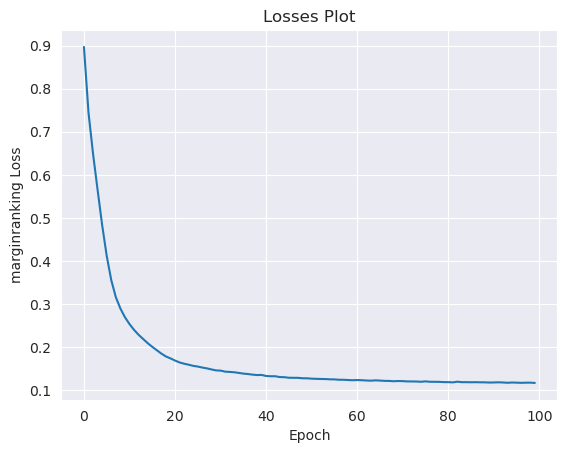

In [38]:
triples_factory = to_embeddings(all_triples, config.results_path)

In [39]:
embeddings_entity_np, embeddings_relation_np, model = load_embeddings(config.results_path)

NumPy Entity Embeddings Array Shape: (45761, 20)
NumPy Relation Embeddings Array Shape: (8, 20)


/tmp/ipykernel_275301/1086840169.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(join(read_from_dir, 'trained_model.pkl'))


## Similarity

In [40]:
src_ids = triples_factory.entities_to_ids([s for s in ni_etl_obj.subjects])

In [41]:
src_vectors = embeddings_entity_np[triples_factory.entities_to_ids(src_ids)]

In [42]:
src_labels = [s for s in ni_etl_obj.subjects]

### Wikidata Similarity

In [43]:
target_ids = triples_factory.entities_to_ids([s for s in wikidata_etl_obj.subjects])

In [44]:
target_vectors = embeddings_entity_np[target_ids]

In [45]:
target_vectors_labels =[s for s in wikidata_etl_obj.subjects]

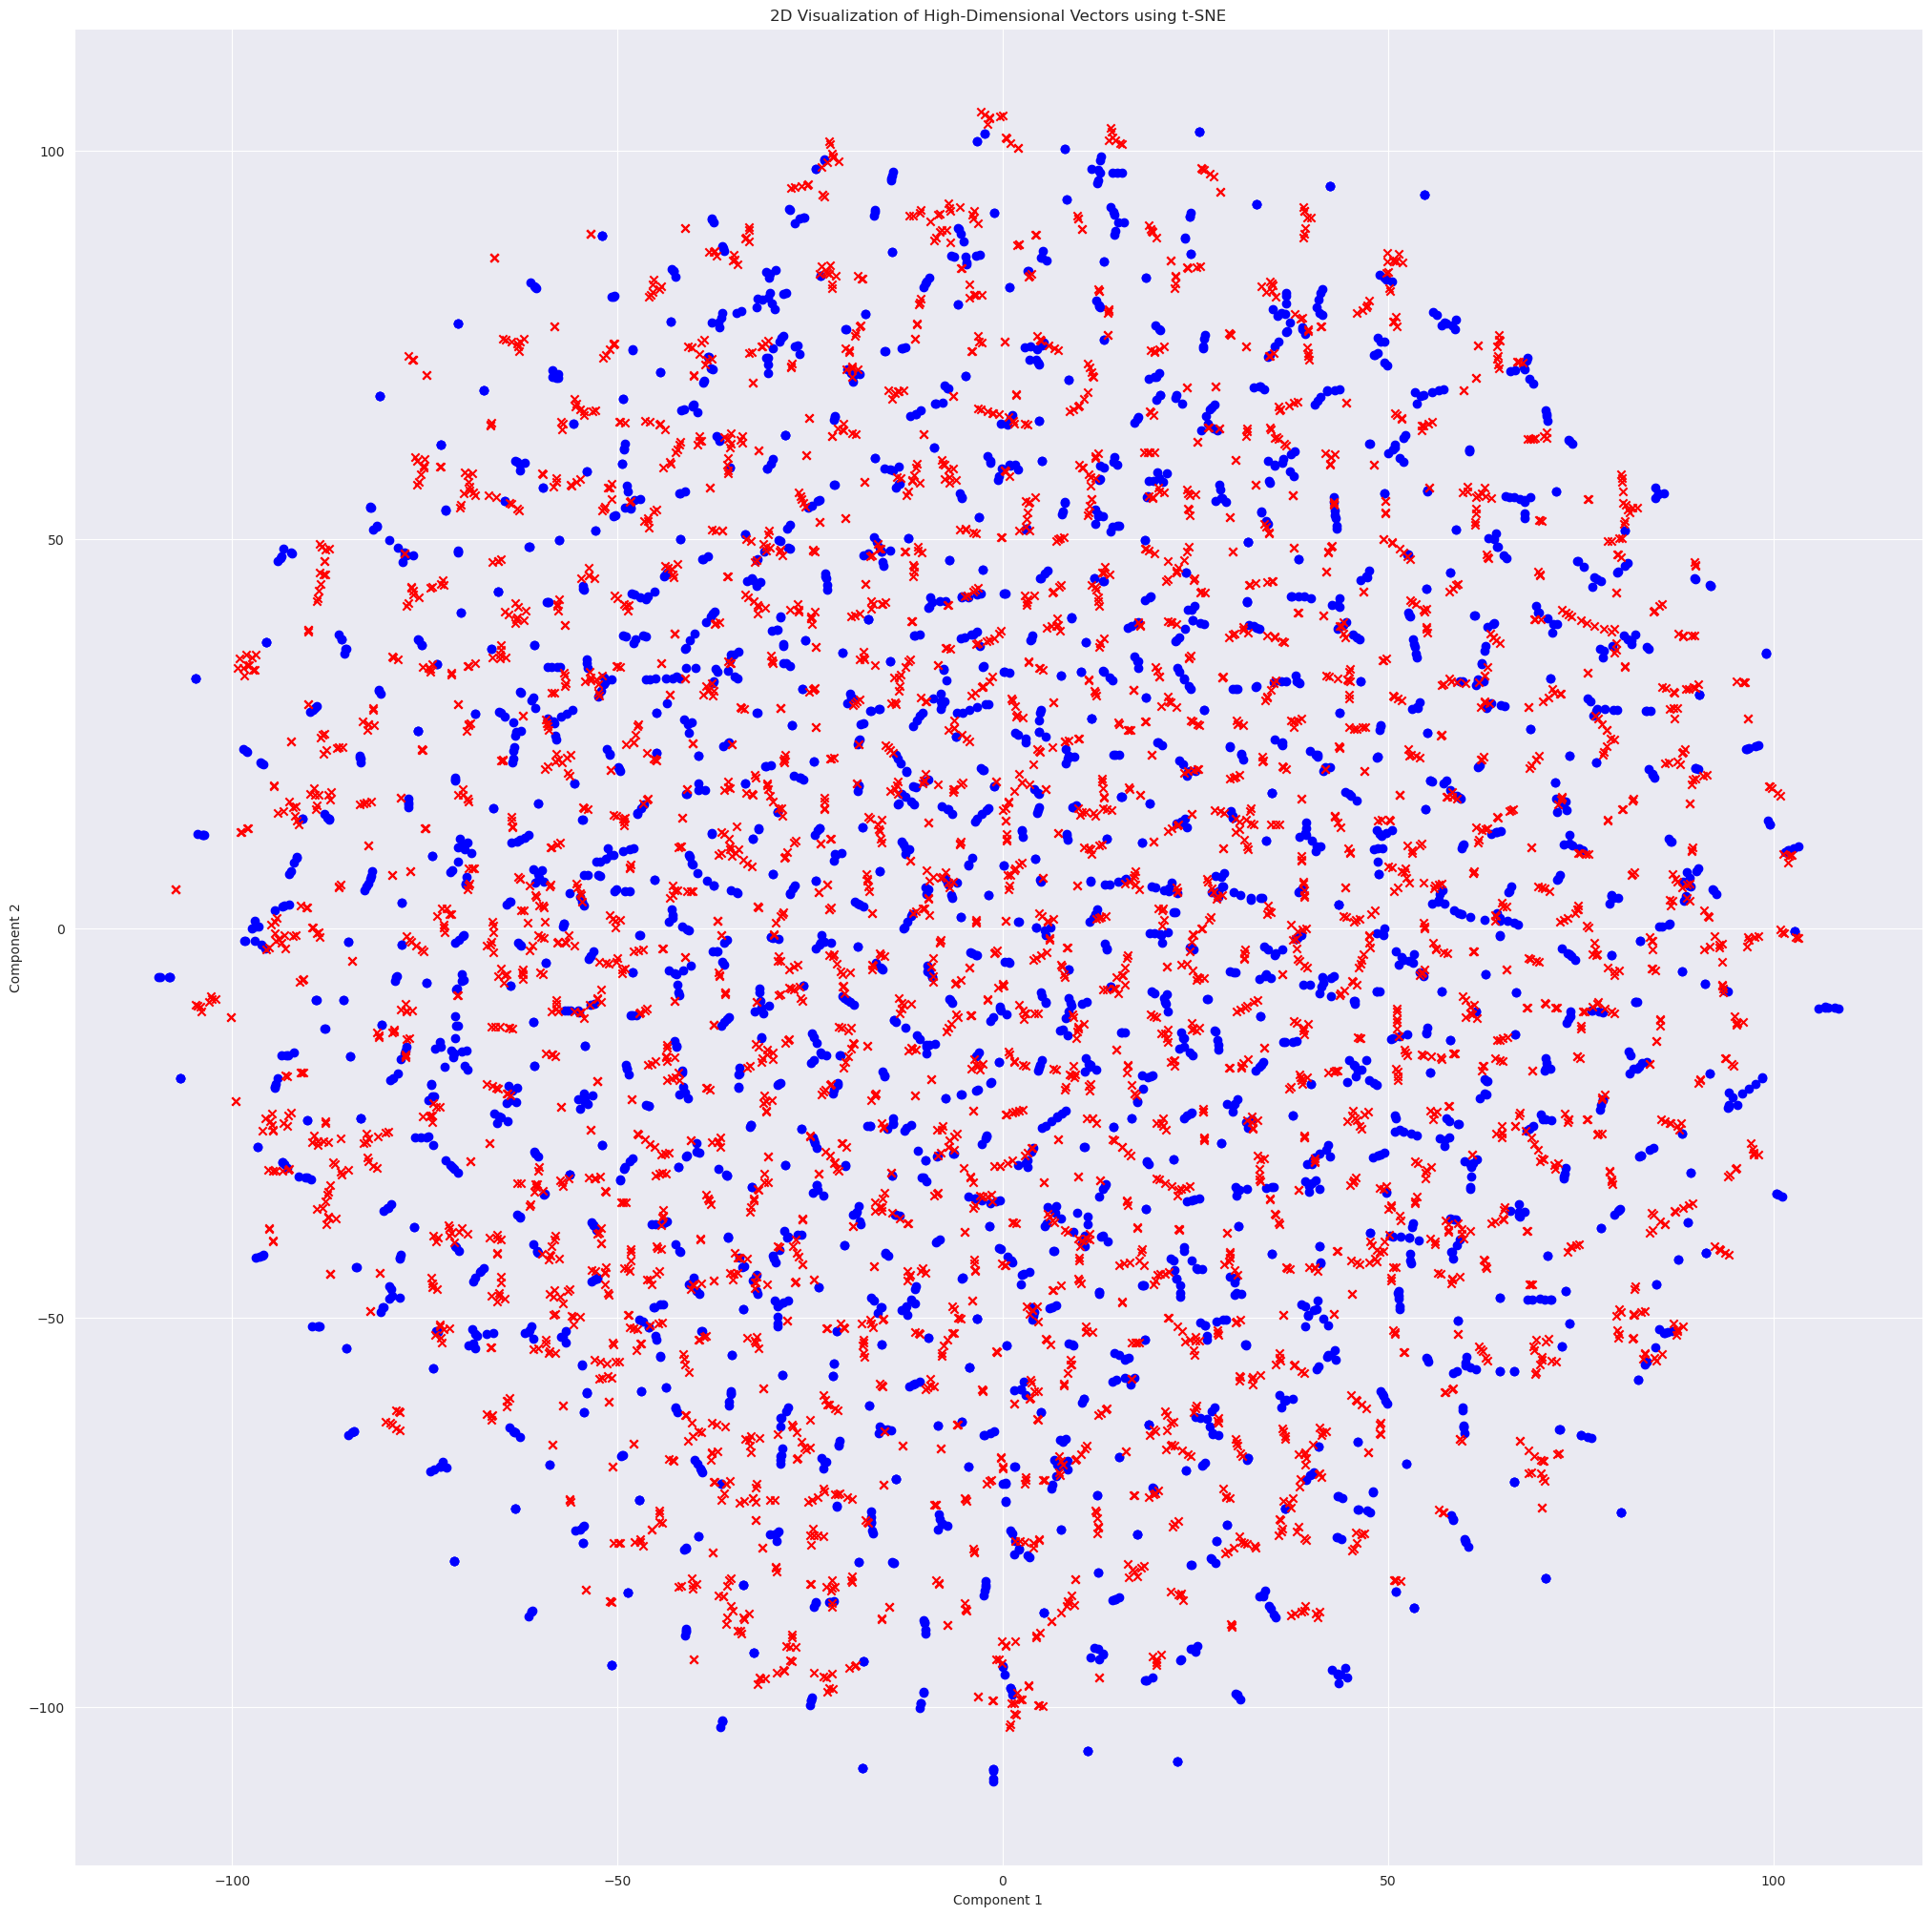

In [46]:
handle_similarity(src_vectors, target_vectors, src_labels, target_vectors_labels, annotate=False)

In [47]:
similar_wiki_pairs_dict = compute_overlap(triples_factory, src_ids, src_vectors, src_labels, target_ids, target_vectors, target_vectors_labels, threshold=0.99)

Subjects 'src_vectors_np' shape: (3064, 20)
Subjects 'vector_vectors_np' shape: (3793, 20)
src: https://collectiedata.hetnieuweinstituut.nl/id/people/10151, dest: http://www.wikidata.org/entity/Q129678692, score: 0.9941
src: https://collectiedata.hetnieuweinstituut.nl/id/people/10192, dest: http://www.wikidata.org/entity/Q2653392, score: 0.9907
src: https://collectiedata.hetnieuweinstituut.nl/id/people/10663, dest: http://www.wikidata.org/entity/Q1697434, score: 0.9949
src: https://collectiedata.hetnieuweinstituut.nl/id/people/10956, dest: http://www.wikidata.org/entity/Q2484772, score: 0.9927
src: https://collectiedata.hetnieuweinstituut.nl/id/people/11049, dest: http://www.wikidata.org/entity/Q1980746, score: 0.9948
src: https://collectiedata.hetnieuweinstituut.nl/id/people/11159, dest: http://www.wikidata.org/entity/Q3019117, score: 0.9984
src: https://collectiedata.hetnieuweinstituut.nl/id/people/11214, dest: http://www.wikidata.org/entity/Q2347515, score: 0.9944
src: https://colle

### Construct Validation Sheet of this round

In [48]:
def creat_validation_sheet(sheet_path, matches_dict, src_triples, target_triples):
    data = {} # where we feed it to a Dataframe
    # create validation sheet based on similar_wiki_pairs_dict entries
    for k, v in matches_dict.items():
        s, d = k[0], k[1]
        sim = v
                        
        data['s'] =  data.get('s', []) + [s]    
      
        probs_s = get_record(src_triples, s)
        for pk, pv in probs_s.items():
            if pk == 'name':
                data[pk] = data.get(pk, []) + [pv]
            
        data['d'] =  data.get('d', []) + [d]
    
    
        probs_d = get_record(target_triples, d)
        for pk, pv in probs_d.items():        
            if  'name' in pk:
                data[f"{pk}.1"] = data.get(f"{pk}.1", []) + [pv]
    
        data['sim'] = data.get('sim', []) + [round(sim, 2)]
    df = pd.DataFrame.from_dict(data, orient='columns', dtype='str')
    df.head(10)
    df.to_csv(sheet_path, index=False)
    print(f'saved to {sheet_path} ...')

In [49]:
validation_path = join(config.validation_sheets_path, 'NIxWikidata.csv')

In [50]:
creat_validation_sheet(validation_path, similar_wiki_pairs_dict, ni_etl_obj.triples, wikidata_etl_obj.triples)

saved to /home/muhammad/Downloads/LOD-Linker/results/validation/NIxWikidata.csv ...


### RKD Similartiy

In [51]:
target_ids = triples_factory.entities_to_ids([s for s in rkd_etl_obj.subjects])

In [52]:
target_vectors = embeddings_entity_np[target_ids]

In [53]:
target_vectors.shape

(4331, 20)

In [54]:
target_vectors_labels =[s for s in rkd_etl_obj.subjects]

In [ ]:
handle_similarity(src_vectors, target_vectors, src_labels, target_vectors_labels, annotate=False)

In [ ]:
similar_rkd_pairs_dict = compute_overlap(triples_factory, src_ids, src_vectors, src_labels, target_ids, target_vectors, target_vectors_labels, threshold=0.98)

In [ ]:
validation_path = join(config.validation_sheets_path, 'NIxRKD.csv')

In [ ]:
creat_validation_sheet(validation_path, similar_rkd_pairs_dict, ni_etl_obj.triples, rkd_etl_obj.triples)

## Show Case

In [ ]:
triples_factory.entities_to_ids(["Zurich"])

In [ ]:
test_src_vec = embeddings_entity_np[13260,:].reshape(1, -1)

In [ ]:
test_src_vec.shape

In [ ]:
triples_factory.entities_to_ids(["The Hague"])

In [ ]:
test_dest_vec = embeddings_entity_np[20543,:].reshape(1, -1)

In [ ]:
test_dest_vec.shape

In [ ]:
cosine_similarity(test_src_vec, test_dest_vec)

In [ ]:
triples_factory.entities_to_ids(["Rotterdam", "Amsterdam"])

In [ ]:
test_src_vec = embeddings_entity_np[19468,:].reshape(1, -1)

In [ ]:
test_dest_vec = embeddings_entity_np[11364,:].reshape(1, -1)

In [ ]:
cosine_similarity(test_src_vec, test_dest_vec)

## References

https://analyticsindiamag.com/ai-mysteries/complete-guide-to-pykeen-python-knowledge-embeddings-for-knowledge-graphs/#h-results


https://github.com/pykeen/pykeen/blob/master/docs/source/tutorial/first_steps.rst#using-learned-embeddings


https://wasit7.medium.com/tutorial-knowledge-graph-embedding-with-pykeen-22d3b7847cea